EPITA 2020 MLRF practice_04-01_BoVW v2020-05-10_154233 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 04 part 01: Bag of Visual Words search engine

We will demonstrate how to use this classical technique to build a global descriptor from local descriptors.

In this session, you will learn how to produce results like the ones displayed below (left column: queries, other columns: responses to query in the same row).

![Sample output](img/practice_04/sample_results.jpg)


We will proceed in 9 steps:

1. Sample some descriptors for codebook learning
2. Learn normalisation parameters for descriptors (mean and eigenvectors)
3. Use k-Means to learn a codebook
4. Compute the BoVW vector for each image
5. Setup a nearest neighbors search structure
6. Evaluate our approach using mean average precision
7. Display some results
8. Compute the best results for the test queries
9. Export the results for the test queries (and submit them for grading).


## Resources
The resources for this session are distributed as a separate archive.
Here is a summary of the files we provide:
- `jpg/*.jpg`: 1491 images;
- `thumbs/*.jpg`: image thumbnails for fast display;
- `siftgeo/*.siftgeo`: associated pre-computed SIFT descriptors for each image;
- `gt_student.json`: a partial ground truth to enable a partial evaluation of the retrieval;
- `queries_for_grading.json`: a list of queries for which you need to submit your results.


## Ground truth format
The ground truth file is a JSON file. Here is an except:
```json
{
 "90314": [
  "90989",
  "91259"
 ],
 "90376": [
  "90674"
 ],
 ...
}
```
It contains a dictionary which associates to each query the list of relevant elements.
Every value is a string representing an image identifier, ie the part of the image or descriptor file without extension.

Example: `"90314"` is the identifier
of the image `jpgs/90314.jpg`
with descriptors available at `siftgeo/90314.siftgeo`
and its thumbnail is `thumbs/90314.jpg`.

Looking at the previous excerpt, we can see that the query `90314` has two relevant results: `90989` and `91259`. 


## Local descriptors
We provide precomputed SIFT descriptors to save you time.
We also provide a commodity function to help you load them (see below).

## 0. Import module, load resources

In [33]:
# deactivate buggy jupyter completion (only if completion is very slow)
%config Completer.use_jedi = False

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [35]:
# FIXME setup the resources location
PATH_TO_RESOURCES = "."

## Code to read descriptors
We provide you with the `siftgeo_read_desc(path)` function which reads the list of descriptors stored in a `.siftgeo` file.

In [36]:
SIFTGEO_DTYPE = np.dtype([
    ("x", "<f4"),
    ("y", "<f4"),
    ("scale", "<f4"),
    ("angle", "<f4"),
    ("mi11", "<f4"),
    ("mi12", "<f4"),
    ("mi21", "<f4"),
    ("mi22", "<f4"),
    ("cornerness", "<f4"),
    ("desdim", "<i4"),
    ("component", "<u1", 128)
])

def siftgeo_read_full(path):
    return np.fromfile(path, dtype=SIFTGEO_DTYPE)

def siftgeo_read_desc(path):
    desc = siftgeo_read_full(path)["component"]
    if desc.size == 0: 
        desc = np.zeros((0, 128), dtype = 'uint8')
    return desc

## Some of utility listings
Again, to save you time, here are some useful lists and mappings:
- `IMG_NAMES_FULL`: list of all full images paths
- `IMG_IDS`: list of image ids (filename without directories nor extension)
- `imgid_to_index`: a mapping from image ids (like `'90000'`, `'90001'`, `'90002'` or `'90003'` — note the quotes indicating string types) to an absolute index in the image list (like `0`, `1`, `2` or `3` — integers). **This will be useful to convert between image paths and rows in the global index.**

In [37]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/thumbs/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./thumbs/90000.jpg',
  './thumbs/90001.jpg',
  './thumbs/90002.jpg',
  './thumbs/90003.jpg',
  './thumbs/90004.jpg'])

In [38]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['90000', '90001', '90002', '90003', '90004'])

In [39]:
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}
#imgid_to_index, type(imgid_to_index)

# 1. Sample some descriptors for codebook learning
Because RAM is not that cheap, loading all descriptors in RAM and fit a k-Means on them usually is impossible.
We will select some image and load the descriptors for those images.

### 1.1 Load descriptors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Randomly select 100 siftgeo files and load the descriptors from them. We will call those descriptors `train_desc`.**
</div>

In [40]:
# TODO sample some images
sample_image_ids = np.random.choice(IMG_IDS ,100)
sample_images = sample_image_ids
sample_images[:5]

array(['90636', '90464', '91339', '90094', '91400'], dtype='<U5')

In [41]:
# TODO load (all) the descriptors for those images
train_desc = []
for imid in sample_images:
    descPath = "./siftgeo/" + imid + ".siftgeo"
    train_desc.append(siftgeo_read_desc(descPath))
len(train_desc), type(train_desc), train_desc[3].shape, type(train_desc[0])

(100, list, (2553, 128), numpy.ndarray)

### 1.2 Prepare those descriptors for training
For those descriptors to be helpful, we need them to be staked in a big single array of shape `(num_desc, desc_len)` where `desc_len` is the length of a single descriptor — here 128 because SIFT decriptors are vectors of 128 integers.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Turn your list of arrays of descriptors in a big single array. Its shape should be something like `(314302, 128)`.**

Hint: look as `numpy.*stack` functions.
</div>

In [42]:
# TODO stack all you descriptors into one big array
train_desc = np.vstack(train_desc)
train_desc.shape, train_desc.dtype

((266933, 128), dtype('uint8'))

Finally, we convert this array to float32 elements to avoid normalization issues.

In [43]:
train_desc = train_desc.astype(np.float32)

## 2. Learn normalisation parameters for descriptors
Before learning a codebook, it is a good practice to:
- center the features;
- reduce their dimension using PCA.

**Warning**: We do NOT REDUCE (divide by the variance) the descriptors here because we want to keep the relative value of the variables. This is indeed the very purpose of histograms!

**This is a first learning step!** Because we will compute a **mean** and **eigenvectors** on a **training set**, we need to **store those values** in order to be able to apply them to test elements later.

### 2.1 Centering descriptors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute and store the mean of your descriptors, then center them.**
</div>

In [44]:
# TODO compute mean and center descriptors
train_mean = np.mean(train_desc)
train_desc = train_desc - train_mean

### 2.2 PCA
We will now compute the PCA parameters which will allow us to reduce the dimension of our descriptors from 128 floats to 64 floats, keeping as much information as possible.

In [45]:
# compute PCA matrix and keep only 64 dimensions
train_cov = np.dot(train_desc.T, train_desc)
eigvals, eigvecs = np.linalg.eig(train_cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
pca_transform = eigvecs[:, perm[64:128]]   # eigenvectors for the 64 last eigenvalues
pca_transform.shape, pca_transform.dtype

((128, 64), dtype('float32'))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Apply the PCA transformation to your descriptors.**

Hint: we expect to get a new `train_desc` array with the same number of rows, but only 64 columns (dimensions).
</div>

In [46]:
# TODO
# perform the appropriate matrix multiplication to transform your descriptors
train_desc = train_desc.dot(pca_transform)

In [47]:
# Check the shape of your new descriptors: we expect a shape like (BIGNUMBER, 64)
train_desc.shape

(266933, 64)

## 3. Use k-Means to learn a codebook
We are now ready to learn a codebook using those centered and compact descriptors.
We will use exactly the same technique as the one we used to compute color histograms:
- first we fit a k-Means;
- then, using the centroids we found, we will project the descriptors and compute bag of features for each image.

In [48]:
from sklearn.cluster import KMeans, MiniBatchKMeans

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Fit a k-Means with 512 clusters on the training descriptors.**
</div>

In [49]:
# TODO fit a k-means (this can take some time; approx. 2 minutes on an 8-cores laptop)
kmeans = MiniBatchKMeans(512).fit(train_desc)

In [50]:
# let's check the shape of the cluster's centers
kmeans.cluster_centers_.shape

(128, 64)

We expect a shape of `(512, 64)` for cluster centers: we have 512 clusters in a 64-dimensional space.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**How do we call this set of cluster centers? They define the set of possible descriptor values we will use to build bag of visual words descriptors. Write down your answer.**
</div>

TODO 
We call this set of cluster centers dictionnary

## 4. Compute the BoVW vector for each image
Using the codebook we just learned, we will compute for each image its bag of features vector (histogram of projected descriptors).

It is almost exaclty like the color histogram we computed in practice session 2!
The **only** difference is that we have much more dimensions.

We will put those descriptors in a naive index made of a single NumPy array.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For each image, compute its BoVW vector.**
</div>

**Beware:**
- in a few images no descriptor was extracted so you need to skip those elements
- you need to apply the same preprocessings than the ones you applied to training descriptors (center, dimension reduction)


In [51]:
# TODO index all images

# Here is our very simple index (keep it initialized like this)
global_image_descr = np.zeros((len(IMG_IDS), kmeans.n_clusters), dtype=np.float32)

for ii, imgid in enumerate(IMG_IDS):
    print("Indexing %s" % (imgid,))
    # read the descriptors
    descPath2 = "./siftgeo/" + imgid + ".siftgeo"
    desc = siftgeo_read_desc(descPath2)
    desc = desc.astype(np.float32)
    
    # handle case where no descriptor is available
    if desc.shape[0] == 0:
        # let the descriptor be 0 for all values
        # note that this is bad and the element should be dropped from the index
        # but here we keep it to preserve image vs desc ids (no worries, it will work)
        print("WARNING: zero descriptor for %s" % (imgid,))
        continue
    
    # apply the same preprocessing as for training descriptors
    mean = np.mean(desc)
    desc = desc - mean
    
    desc = desc.dot(pca_transform)

    # get cluster ids
    clusterId = kmeans.predict(desc)
    
    # compute histogram (do not forget to normalize by the number of descriptors)
    descr_hist = np.bincount(clusterId, minlength=kmeans.n_clusters) / desc.shape[0]

    # update the index
    global_image_descr[ii] = descr_hist
print("Indexing complete.")
global_image_descr.shape, global_image_descr.dtype


Indexing 90166
Indexing 90167
Indexing 90168
Indexing 90169
Indexing 90170
Indexing 90171
Indexing 90172
Indexing 90173
Indexing 90174
Indexing 90175
Indexing 90176
Indexing 90177
Indexing 90178
Indexing 90179
Indexing 90180
Indexing 90181
Indexing 90182
Indexing 90183
Indexing 90184
Indexing 90185
Indexing 90186
Indexing 90187
Indexing 90188
Indexing 90189
Indexing 90190
Indexing 90191
Indexing 90192
Indexing 90193
Indexing 90194
Indexing 90195
Indexing 90196
Indexing 90197
Indexing 90198
Indexing 90199
Indexing 90200
Indexing 90201
Indexing 90202
Indexing 90203
Indexing 90204
Indexing 90205
Indexing 90206
Indexing 90207
Indexing 90208
Indexing 90209
Indexing 90210
Indexing 90211
Indexing 90212
Indexing 90213
Indexing 90214
Indexing 90215
Indexing 90216
Indexing 90217
Indexing 90218
Indexing 90219
Indexing 90220
Indexing 90221
Indexing 90222
Indexing 90223
Indexing 90224
Indexing 90225
Indexing 90226
Indexing 90227
Indexing 90228
Indexing 90229
Indexing 90230
Indexing 90231
Indexing 

((1491, 128), dtype('float32'))

In [52]:
'''# TODO index all images

globalHistogram = np.zeros((kmeans.n_clusters,))

# Here is our very simple index (keep it initialized like this)
global_image_descr = np.zeros((len(IMG_IDS), kmeans.n_clusters), dtype=np.float32)

for ii, imgid in enumerate(IMG_IDS):
    print("Indexing %s" % (imgid,))
    # read the descriptors
    descPath2 = "./siftgeo/" + imgid + ".siftgeo"
    desc = siftgeo_read_desc(descPath2)
    desc = desc.astype(np.float32)
    
    # handle case where no descriptor is available
    if desc.shape[0] == 0:
        # let the descriptor be 0 for all values
        # note that this is bad and the element should be dropped from the index
        # but here we keep it to preserve image vs desc ids (no worries, it will work)
        print("WARNING: zero descriptor for %s" % (imgid,))
        continue
    
    # apply the same preprocessing as for training descriptors
    mean = np.mean(desc)
    desc = desc - mean
    
    desc = desc.dot(pca_transform)

    # get cluster ids
    clusterId = kmeans.predict(desc)
    
    # compute histogram (do not forget to normalize by the number of descriptors)
    descr_hist = np.bincount(clusterId, minlength=kmeans.n_clusters)

    globalHistogram += descr_hist

    descr_hist = descr_hist.astype(np.float64)

    descr_hist /= desc.shape[0]

    # update the index
    global_image_descr[ii] = descr_hist
print("Indexing complete.")

global_image_descr *= np.log(len(IMG_IDS) / globalHistogram)

global_image_descr.shape, global_image_descr.dtype'''

'# TODO index all images\n\nglobalHistogram = np.zeros((kmeans.n_clusters,))\n\n# Here is our very simple index (keep it initialized like this)\nglobal_image_descr = np.zeros((len(IMG_IDS), kmeans.n_clusters), dtype=np.float32)\n\nfor ii, imgid in enumerate(IMG_IDS):\n    print("Indexing %s" % (imgid,))\n    # read the descriptors\n    descPath2 = "./siftgeo/" + imgid + ".siftgeo"\n    desc = siftgeo_read_desc(descPath2)\n    desc = desc.astype(np.float32)\n    \n    # handle case where no descriptor is available\n    if desc.shape[0] == 0:\n        # let the descriptor be 0 for all values\n        # note that this is bad and the element should be dropped from the index\n        # but here we keep it to preserve image vs desc ids (no worries, it will work)\n        print("WARNING: zero descriptor for %s" % (imgid,))\n        continue\n    \n    # apply the same preprocessing as for training descriptors\n    mean = np.mean(desc)\n    desc = desc - mean\n    \n    desc = desc.dot(pca_tra

## 5. Setup a nearest neighbors search structure
We will use a simple nearest neighbors implementatio to test our approach.

In [53]:
from sklearn.neighbors import NearestNeighbors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using scikit-learn's implementation of nearest neighbors, setup a search engine with a linear search strategy and an appropriate metric.**
</div>

In [54]:
# TODO setup search engine
search_engine = NearestNeighbors(algorithm='brute', metric='cosine')

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now index you descriptors.**
</div>

In [55]:
# TODO index descriptors
search_engine.fit(global_image_descr)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## 6. Evaluate our approach using mean average precision
We can now evaluate the performance of our search engine using the available ground truth.

### 6.1 Load the ground truth
The ground truth is a simple dictionary mapping query ids to relevant image ids:
```json
{'90314': ['90989', '91259'],
 '90376': ['90674'],
 '90175': ['90512'],
 ...
}
```

In [56]:
import json

PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "gt_student.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

### 6.3 Select the descriptors of the query images

The annoying part is to convert between the indices of the elements in our index structure `global_image_descr` and the images ids which allow us to find files.

The upside is that reusing the precomputed descriptors avoids us the need for computing the BoVW vector for each query image.

We use the `imgid_to_index`, which helps us converting between image ids (filename without directory nor extension) and index value in the `global_image_descr` array, to recover the indices of the rows corresponding to the query images in `global_image_descr`.

Here is below some code you should run and try to understand.

In [57]:
# get the indices of the query images
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]
type(query_imnos)

list

In [58]:
#imgid_to_index

In [59]:
#query_imnos

In [60]:
IMG_IDS[query_imnos[0]]

'90314'

In [61]:
gt_data[IMG_IDS[query_imnos[0]]]

['90989', '91259']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using `query_imnos`, you can now select the descriptors of the query images from the precomputed array `global_image_descr`.**
</div>

In [62]:
# TODO select the descriptors of the query images
query_vectors = [global_image_descr[i] for i in query_imnos]
type(query_imnos), len(query_imnos)

(list, 250)

### 6.4 Run the query

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Run a search query for all query images using our search engine. Ask for 9 neighbors because we want 8 real results and we will later remove the query from the list of results (we expect it the be the first result here, because our queries belong to our database for testing purposes).**
</div>

In [63]:
# TODO
# get the 9 (8 real) NNs for all query images
distances, results = search_engine.kneighbors(query_vectors, 9)
results.shape

(250, 9)

We expect here a shape of `(250, 9)` for the results.

### 6.4 Evaluate the performance using mAP
The mean average precision is the mean of the AP computed for each query.
The AP is the area under the precision-recall curve.

For each query, we will therefore sum the areas of the trapezoids between each recall values.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the code below to compute the mean average precision of our search engine on the training set.**

Hint: you should get a value much higher than what random results would produce ($0.001$ in our tests but you can simulate this yourself).
</div>

In [64]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        ap += ((precision_1 + precision_0) / 2) * recall_step  # FIXME what is the area under the PR curve?
    print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print("mean AP = %.3f" % np.mean(aps))  # FIXME mean average precision

query 90314, AP = 0.083
query 90376, AP = 1.000
query 90175, AP = 0.000
query 90949, AP = 1.000
query 90818, AP = 0.000
query 91374, AP = 0.000
query 90696, AP = 0.000
query 90464, AP = 1.000
query 90413, AP = 0.000
query 90356, AP = 1.000
query 90185, AP = 0.000
query 90284, AP = 1.000
query 90341, AP = 0.125
query 90783, AP = 0.000
query 90529, AP = 1.000
query 90721, AP = 1.000
query 91298, AP = 0.071
query 91437, AP = 1.000
query 90153, AP = 0.000
query 90581, AP = 0.000
query 90439, AP = 0.250
query 90841, AP = 0.000
query 91069, AP = 0.500
query 90766, AP = 0.667
query 90359, AP = 0.500
query 90081, AP = 0.167
query 90126, AP = 1.000
query 90531, AP = 1.000
query 90503, AP = 0.000
query 90093, AP = 0.000
query 90222, AP = 0.050
query 90977, AP = 0.238
query 90180, AP = 0.000
query 91246, AP = 0.000
query 90690, AP = 1.000
query 90669, AP = 1.000
query 90173, AP = 1.000
query 90484, AP = 0.792
query 91464, AP = 0.167
query 90631, AP = 0.182
query 91241, AP = 1.000
query 90041, AP 

## 7. Display some results
We provide you with some code to display query results.

<Figure size 432x288 with 0 Axes>

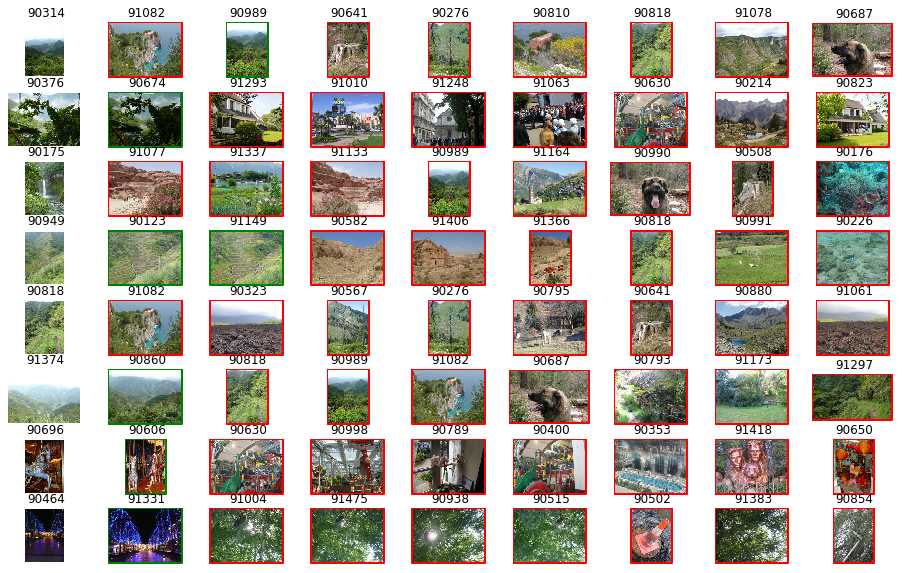

In [33]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 8   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread(os.path.join(PATH_TO_RESOURCES, "thumbs", "%s.jpg" % IMG_IDS[imno]))
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(16,10))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()

## 8. Compute the best results for the test queries
You are now ready to process the test data for the grading.

We provide you with a set of query ids, and you must produce the list of most releveant results for each.

In [34]:
test_queries = None
with open(os.path.join(PATH_TO_RESOURCES, "queries_for_grading.json")) as qin:
    test_queries = json.load(qin)
test_queries[:10]

['91401',
 '91274',
 '90136',
 '91071',
 '91221',
 '90274',
 '90240',
 '90662',
 '90169',
 '90751']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For each query, compute the list of best results.**
</div>

In [35]:
# TODO everything
query_imnos2 = [imgid_to_index[query_id] for query_id in test_queries]
query_vectors2 = [global_image_descr[i] for i in query_imnos2]
distances, test_results = search_engine.kneighbors(query_vectors2, 9)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display your results to control them visually. Make sure you really perform this step because the train and test sets have the same size here, and it is easy to get confused and submit the wrong set!**
</div>

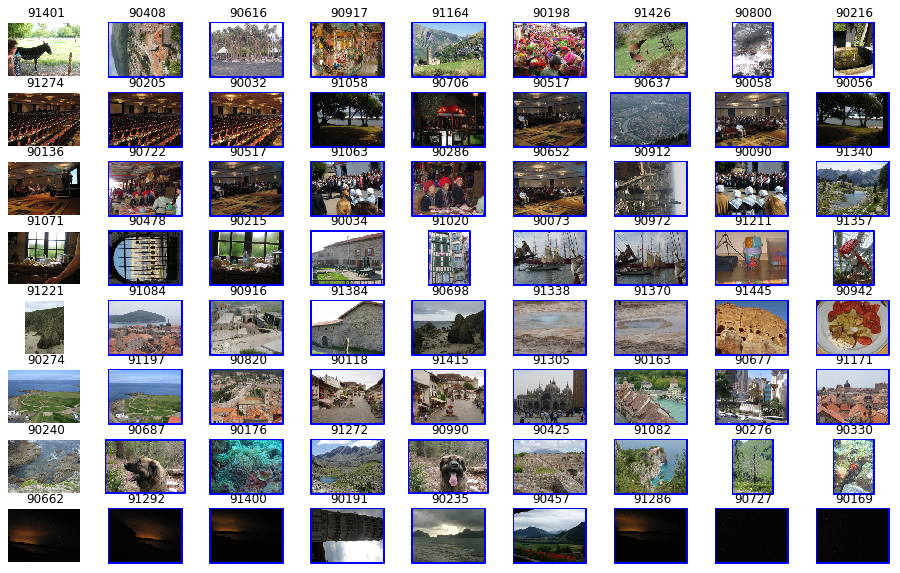

In [36]:
# TODO
plt.figure(figsize=(16,10))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos2[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(test_results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        show_image(qres, 'b')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show()


## 9. Export the results for the test queries

Here is some code to export your results in the appropriate format.

**Do not forget to submit them!**

In [37]:
results = {query_id: [IMG_IDS[ri] for ri in results_ids[1:]]
           for query_id,results_ids in zip(test_queries, test_results)}

In [38]:
EXPORT_PATH = "results.json"

In [39]:
with open(EXPORT_PATH, 'w') as outres:
    json.dump(results, outres, indent=1)
!head $EXPORT_PATH

{
 "91401": [
  "90408",
  "90616",
  "90917",
  "91164",
  "90198",
  "91426",
  "90800",
  "90216"


# Job done!
Do you think you can improve the performance of your approach and get a better grading?